# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


/home/hung/.conda/envs/cv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


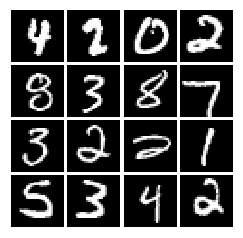

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, tf.multiply(x, alpha))


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], minval=-1, maxval=1)


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        fc1 = tf.contrib.layers.fully_connected(x, 256, activation_fn=None)
        relu1 = leaky_relu(fc1, alpha=0.01)
        fc2 = tf.contrib.layers.fully_connected(relu1, 256, activation_fn=None)
        relu2 = leaky_relu(fc2, alpha=0.01)
        logits = tf.contrib.layers.fully_connected(relu2, 1, activation_fn=None)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.contrib.layers.fully_connected(z, 1024, activation_fn=tf.nn.relu)
        fc2 = tf.contrib.layers.fully_connected(fc1, 1024, activation_fn=tf.nn.relu)
        img = tf.contrib.layers.fully_connected(fc2, 784, activation_fn=tf.nn.tanh)
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake),\
                                                                    logits=logits_fake))
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real),\
                                                                   logits=logits_real))\
            + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake),\
                                                                    logits=logits_fake))
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 6.02597e-17
Maximum error in g_loss: 7.19722e-17


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=20):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

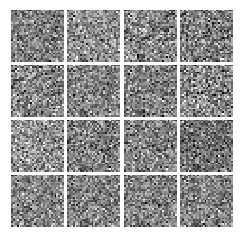


Iter: 0, D: 1.094, G:0.7047
Iter: 50, D: 0.2026, G:1.938
Iter: 100, D: 0.6203, G:1.337
Iter: 150, D: 1.709, G:0.8803
Iter: 200, D: 1.49, G:0.9224


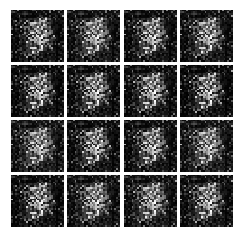


Iter: 250, D: 1.338, G:1.051
Iter: 300, D: 1.491, G:0.9478
Iter: 350, D: 1.292, G:1.078
Iter: 400, D: 1.176, G:1.153
Iter: 450, D: 1.4, G:0.7692


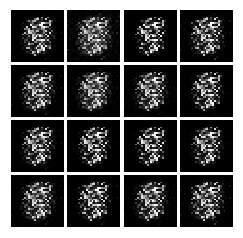


Iter: 500, D: 1.258, G:0.9114
Iter: 550, D: 1.171, G:1.643
Iter: 600, D: 1.385, G:0.8108
Iter: 650, D: 1.164, G:0.8409
Iter: 700, D: 1.232, G:0.9001


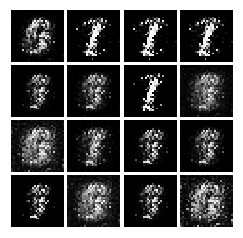


Iter: 750, D: 1.23, G:0.8209
Iter: 800, D: 1.2, G:1.753
Iter: 850, D: 1.23, G:0.5549
Iter: 900, D: 1.565, G:0.6991
Iter: 950, D: 1.187, G:0.4371


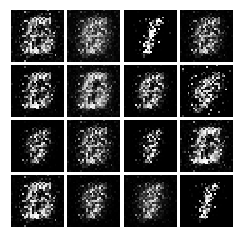


Iter: 1000, D: 1.117, G:1.21
Iter: 1050, D: 1.216, G:1.104
Iter: 1100, D: 0.9966, G:1.383
Iter: 1150, D: 0.7969, G:5.123
Iter: 1200, D: 1.323, G:0.4994


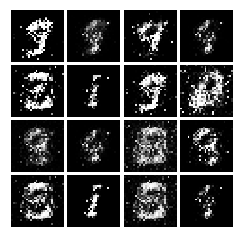


Iter: 1250, D: 0.9567, G:1.047
Iter: 1300, D: 1.302, G:1.416
Iter: 1350, D: 1.317, G:1.272
Iter: 1400, D: 1.108, G:2.012
Iter: 1450, D: 1.34, G:1.003


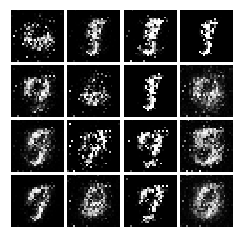


Iter: 1500, D: 1.065, G:1.334
Iter: 1550, D: 1.233, G:1.252
Iter: 1600, D: 1.122, G:1.327
Iter: 1650, D: 1.304, G:0.7914
Iter: 1700, D: 1.302, G:0.7824


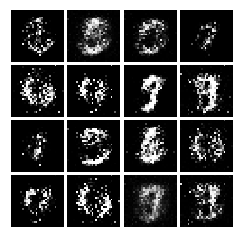


Iter: 1750, D: 1.292, G:0.8126
Iter: 1800, D: 1.309, G:0.8243
Iter: 1850, D: 1.104, G:1.353
Iter: 1900, D: 1.283, G:1.088
Iter: 1950, D: 1.345, G:0.8668


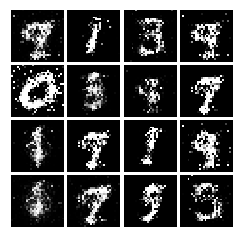


Iter: 2000, D: 1.264, G:0.8339
Iter: 2050, D: 1.429, G:0.8349
Iter: 2100, D: 1.233, G:0.8681
Iter: 2150, D: 1.258, G:0.8594
Iter: 2200, D: 1.267, G:1.017


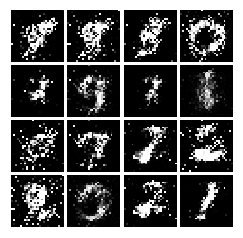


Iter: 2250, D: 1.36, G:0.9381
Iter: 2300, D: 1.358, G:0.8771
Iter: 2350, D: 1.253, G:0.8267
Iter: 2400, D: 1.286, G:0.7584
Iter: 2450, D: 1.341, G:0.8026


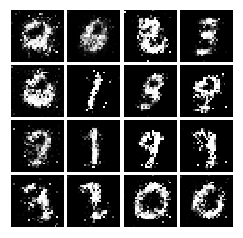


Iter: 2500, D: 1.33, G:0.877
Iter: 2550, D: 1.27, G:0.8317
Iter: 2600, D: 1.297, G:0.8907
Iter: 2650, D: 1.3, G:0.7596
Iter: 2700, D: 1.376, G:0.8093


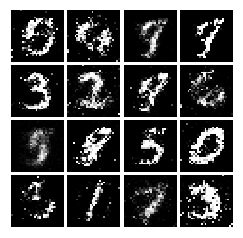


Iter: 2750, D: 1.326, G:0.8297
Iter: 2800, D: 1.288, G:0.7993
Iter: 2850, D: 1.285, G:1.011
Iter: 2900, D: 1.653, G:0.8307
Iter: 2950, D: 1.414, G:0.6657


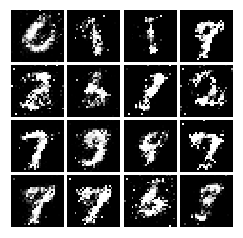


Iter: 3000, D: 1.303, G:0.7991
Iter: 3050, D: 1.317, G:0.7622
Iter: 3100, D: 1.322, G:0.8171
Iter: 3150, D: 1.373, G:0.7807
Iter: 3200, D: 1.323, G:0.7855


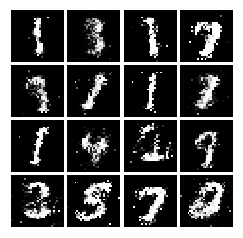


Iter: 3250, D: 1.254, G:0.7562
Iter: 3300, D: 1.288, G:0.7888
Iter: 3350, D: 1.205, G:0.7218
Iter: 3400, D: 1.273, G:0.8737
Iter: 3450, D: 1.317, G:0.8308


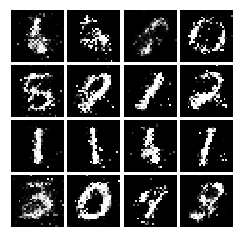


Iter: 3500, D: 1.284, G:0.7765
Iter: 3550, D: 1.323, G:0.9826
Iter: 3600, D: 1.318, G:0.7489
Iter: 3650, D: 1.319, G:0.761
Iter: 3700, D: 1.341, G:0.8444


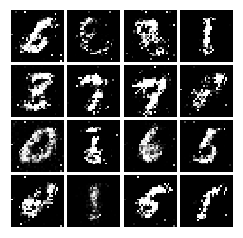


Iter: 3750, D: 1.335, G:0.8762
Iter: 3800, D: 1.281, G:0.811
Iter: 3850, D: 1.363, G:0.8447
Iter: 3900, D: 1.324, G:0.8043
Iter: 3950, D: 1.313, G:0.7752


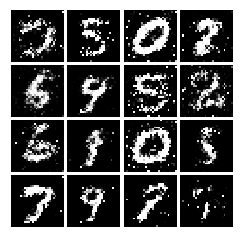


Iter: 4000, D: 1.436, G:0.9566
Iter: 4050, D: 1.394, G:0.794
Iter: 4100, D: 1.299, G:0.8904
Iter: 4150, D: 1.3, G:0.7586
Iter: 4200, D: 1.344, G:0.7976


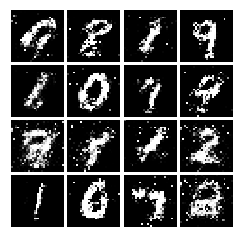


Iter: 4250, D: 1.357, G:0.8389
Iter: 4300, D: 1.334, G:0.7491
Iter: 4350, D: 1.299, G:0.816
Iter: 4400, D: 1.351, G:0.7764
Iter: 4450, D: 1.315, G:0.7963


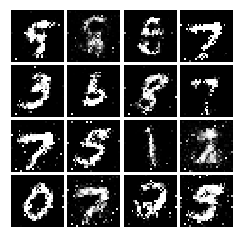


Iter: 4500, D: 1.32, G:0.8602
Iter: 4550, D: 1.278, G:0.8651
Iter: 4600, D: 1.311, G:0.8979
Iter: 4650, D: 1.302, G:0.7729
Iter: 4700, D: 1.278, G:0.8153


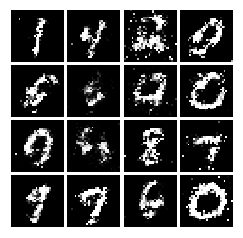


Iter: 4750, D: 1.342, G:0.7596
Iter: 4800, D: 1.336, G:0.8271
Iter: 4850, D: 1.289, G:0.7798
Iter: 4900, D: 1.349, G:0.7989
Iter: 4950, D: 1.326, G:0.7528


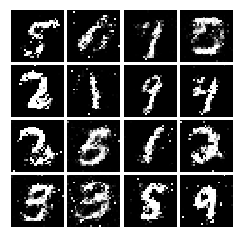


Iter: 5000, D: 1.355, G:0.811
Iter: 5050, D: 1.344, G:0.7783
Iter: 5100, D: 1.308, G:0.8677
Iter: 5150, D: 1.301, G:0.7441
Iter: 5200, D: 1.293, G:0.8144


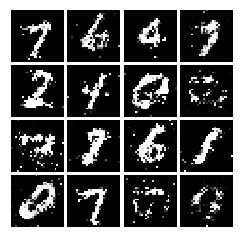


Iter: 5250, D: 1.312, G:0.8934
Iter: 5300, D: 1.36, G:0.8274
Iter: 5350, D: 1.327, G:0.9018
Iter: 5400, D: 1.327, G:0.8403
Iter: 5450, D: 1.317, G:0.801


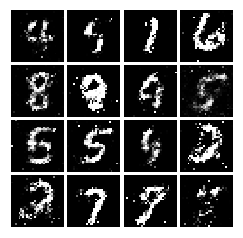


Iter: 5500, D: 1.277, G:0.6798
Iter: 5550, D: 1.322, G:0.8019
Iter: 5600, D: 1.359, G:0.7826
Iter: 5650, D: 1.432, G:0.9075
Iter: 5700, D: 1.307, G:0.813


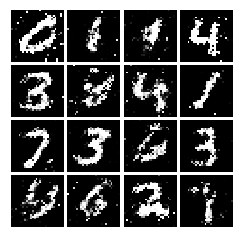


Iter: 5750, D: 1.294, G:0.8372
Iter: 5800, D: 1.282, G:0.8872
Iter: 5850, D: 1.326, G:0.7492
Iter: 5900, D: 1.292, G:0.8295
Iter: 5950, D: 1.316, G:0.7416


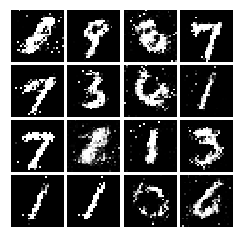


Iter: 6000, D: 1.261, G:0.8526
Iter: 6050, D: 1.271, G:0.829
Iter: 6100, D: 1.28, G:0.8019
Iter: 6150, D: 1.334, G:0.8775
Iter: 6200, D: 1.365, G:0.8451


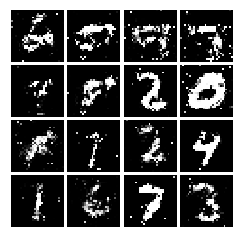


Iter: 6250, D: 1.335, G:0.8682
Iter: 6300, D: 1.315, G:0.7474
Iter: 6350, D: 1.301, G:0.8415
Iter: 6400, D: 1.33, G:0.788
Iter: 6450, D: 1.328, G:0.8396


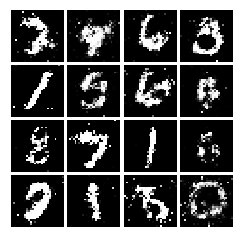


Iter: 6500, D: 1.341, G:0.7443
Iter: 6550, D: 1.276, G:0.7165
Iter: 6600, D: 1.303, G:0.7895
Iter: 6650, D: 1.339, G:0.8512
Iter: 6700, D: 1.323, G:0.7975


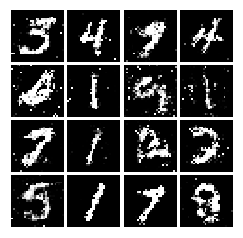


Iter: 6750, D: 1.324, G:0.8036
Iter: 6800, D: 1.349, G:0.8242
Iter: 6850, D: 1.311, G:0.9109
Iter: 6900, D: 1.298, G:0.8465
Iter: 6950, D: 1.284, G:0.8089


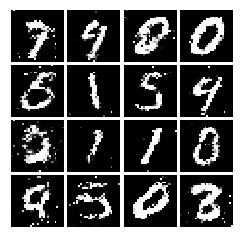


Iter: 7000, D: 1.312, G:0.7799
Iter: 7050, D: 1.355, G:0.8725
Iter: 7100, D: 1.326, G:0.8457
Iter: 7150, D: 1.292, G:0.7585
Iter: 7200, D: 1.342, G:0.8127


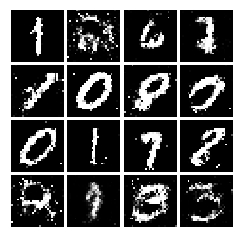


Iter: 7250, D: 1.31, G:0.8998
Iter: 7300, D: 1.311, G:1.006
Iter: 7350, D: 1.303, G:0.9006
Iter: 7400, D: 1.325, G:0.7254
Iter: 7450, D: 1.339, G:0.9236


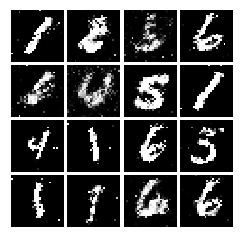


Iter: 7500, D: 1.321, G:0.8593
Iter: 7550, D: 1.279, G:0.853
Iter: 7600, D: 1.287, G:0.8214
Iter: 7650, D: 1.3, G:0.8535
Iter: 7700, D: 1.288, G:0.8869


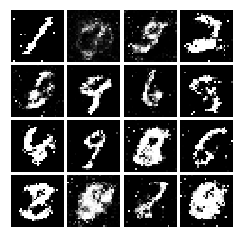


Iter: 7750, D: 1.325, G:0.7872
Iter: 7800, D: 1.261, G:0.8714
Iter: 7850, D: 1.332, G:0.8356
Iter: 7900, D: 1.297, G:0.9191
Iter: 7950, D: 1.266, G:1.411


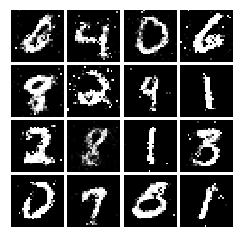


Iter: 8000, D: 1.306, G:0.8001
Iter: 8050, D: 1.284, G:0.9659
Iter: 8100, D: 1.142, G:1.204
Iter: 8150, D: 1.285, G:1.021
Iter: 8200, D: 1.217, G:0.9475


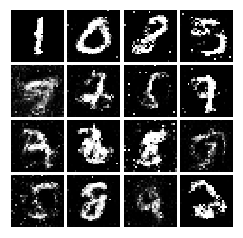


Iter: 8250, D: 1.274, G:0.8692
Iter: 8300, D: 1.278, G:0.9176
Iter: 8350, D: 1.236, G:0.9037
Iter: 8400, D: 1.182, G:1.034
Iter: 8450, D: 1.252, G:0.8979


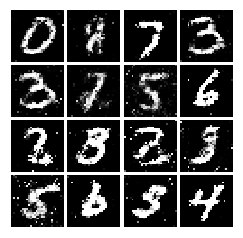


Iter: 8500, D: 1.182, G:0.8633
Iter: 8550, D: 1.31, G:0.9611
Final images


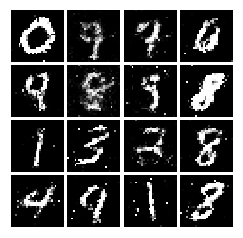

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [ ]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = 0.5 * tf.reduce_mean(tf.square(score_fake-1))
    D_loss = 0.5 * tf.reduce_mean(tf.square(score_real-1)) + 0.5 * tf.reduce_mean(tf.square(score_fake))
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [ ]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Create new training steps so we instead minimize the LSGAN loss:

In [ ]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** (Write Your Answer In This Cell) **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [17]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x, [-1, 28, 28 ,1])
        conv1 = tf.layers.conv2d(x, 32, 5, activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(conv1, 2, 2)
        conv2 = tf.layers.conv2d(pool1, 64, 5, activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(conv2, 2, 2)
        flatten1 = tf.contrib.layers.flatten(pool2)
        fc1 = tf.contrib.layers.fully_connected(flatten1, 4 * 4 * 64, activation_fn=leaky_relu)
        fc2 = tf.contrib.layers.fully_connected(fc1, 1, activation_fn=None)
        return fc2
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [18]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.contrib.layers.fully_connected(z, 1024)
        bn1 = tf.layers.batch_normalization(fc1)
        fc2 = tf.contrib.layers.fully_connected(bn1, 7 * 7 * 128)
        bn2 = tf.layers.batch_normalization(fc2)
        img = tf.reshape(bn2, [-1, 7, 7, 128])
        conv1 = tf.layers.conv2d_transpose(img, 64, 4, 2, padding='same', activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(conv1)
        conv2 = tf.layers.conv2d_transpose(bn2, 1, 4, 2, padding='same', activation=tf.tanh)
        img = tf.reshape(conv2, [-1, 784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [19]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

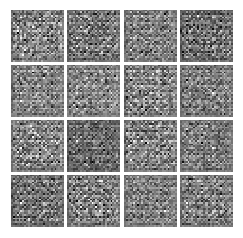


Iter: 0, D: 1.359, G:0.6561
Iter: 50, D: 0.01129, G:4.916
Iter: 100, D: 1.239, G:6.25
Iter: 150, D: 0.6361, G:6.783
Iter: 200, D: 0.7709, G:4.09


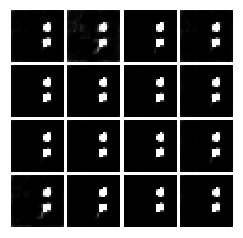


Iter: 250, D: 0.09719, G:3.758
Iter: 300, D: 0.2232, G:3.244
Iter: 350, D: 0.3829, G:3.938
Iter: 400, D: 0.4303, G:3.542
Iter: 450, D: 0.9671, G:1.964


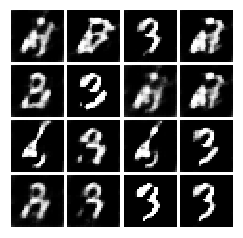


Iter: 500, D: 0.5859, G:2.461
Iter: 550, D: 0.3909, G:2.739
Iter: 600, D: 0.6051, G:4.393
Iter: 650, D: 0.2993, G:3.128
Iter: 700, D: 0.4156, G:2.237


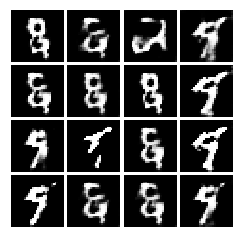


Iter: 750, D: 0.6054, G:1.176
Iter: 800, D: 0.4902, G:3.85
Iter: 850, D: 0.4333, G:1.925
Iter: 900, D: 0.5229, G:2.351
Iter: 950, D: 0.6434, G:1.943


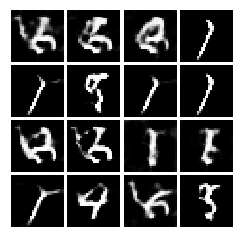


Iter: 1000, D: 0.3036, G:3.069
Iter: 1050, D: 0.3334, G:2.626
Iter: 1100, D: 0.6197, G:1.836
Iter: 1150, D: 0.4262, G:2.506
Iter: 1200, D: 0.5484, G:2.13


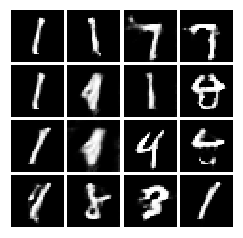


Iter: 1250, D: 0.6872, G:1.786
Iter: 1300, D: 0.7711, G:1.562
Iter: 1350, D: 0.6795, G:2.068
Iter: 1400, D: 0.7748, G:2.62
Iter: 1450, D: 0.664, G:2.065


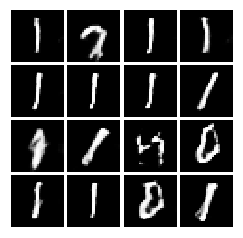


Iter: 1500, D: 0.5292, G:1.992
Iter: 1550, D: 0.7094, G:1.635
Iter: 1600, D: 0.697, G:1.543
Iter: 1650, D: 0.5738, G:1.86
Iter: 1700, D: 0.6911, G:1.788


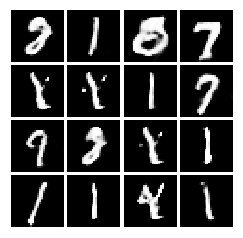


Iter: 1750, D: 0.7338, G:1.658
Iter: 1800, D: 0.8183, G:1.994
Iter: 1850, D: 0.7092, G:1.614
Iter: 1900, D: 0.7261, G:1.406
Iter: 1950, D: 0.6566, G:1.852


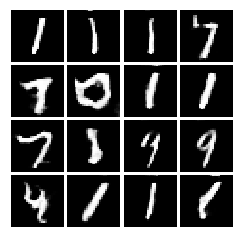


Iter: 2000, D: 0.7897, G:1.536
Iter: 2050, D: 0.7317, G:1.527
Iter: 2100, D: 0.6705, G:2.01
Iter: 2150, D: 0.6576, G:1.849
Iter: 2200, D: 0.707, G:1.579


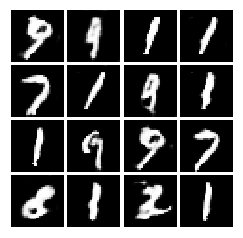


Iter: 2250, D: 0.7107, G:1.874
Iter: 2300, D: 0.618, G:1.95
Iter: 2350, D: 0.7722, G:1.511
Iter: 2400, D: 0.6453, G:1.839
Iter: 2450, D: 0.6762, G:1.598


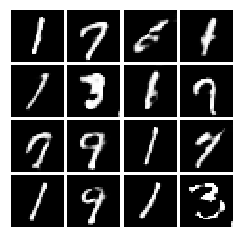


Iter: 2500, D: 0.6986, G:1.744
Iter: 2550, D: 0.7138, G:1.28
Iter: 2600, D: 0.6918, G:1.623
Iter: 2650, D: 0.6843, G:1.59
Iter: 2700, D: 0.7275, G:1.938


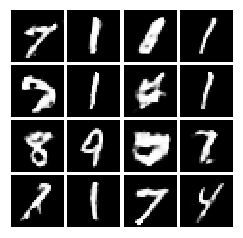


Iter: 2750, D: 0.6794, G:1.827
Iter: 2800, D: 0.7775, G:1.369
Iter: 2850, D: 0.5995, G:2.519
Iter: 2900, D: 0.6995, G:1.684
Iter: 2950, D: 0.7234, G:1.821


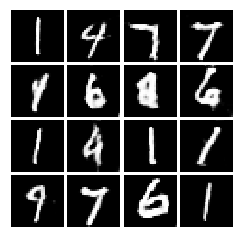


Iter: 3000, D: 0.6797, G:1.905
Iter: 3050, D: 0.6912, G:1.879
Iter: 3100, D: 0.6973, G:1.369
Iter: 3150, D: 0.6719, G:1.558
Iter: 3200, D: 0.6954, G:1.425


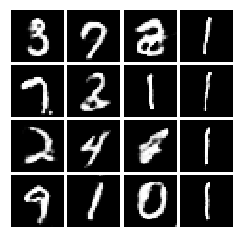


Iter: 3250, D: 0.6668, G:1.49
Iter: 3300, D: 0.802, G:1.387
Iter: 3350, D: 0.7244, G:1.834
Iter: 3400, D: 0.7762, G:2.21
Iter: 3450, D: 0.7385, G:2.2


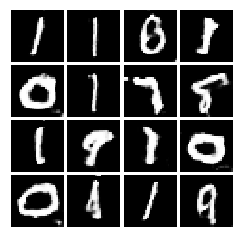


Iter: 3500, D: 0.649, G:1.303
Iter: 3550, D: 0.7756, G:1.427
Iter: 3600, D: 0.7448, G:2.255
Iter: 3650, D: 0.7102, G:1.247
Iter: 3700, D: 0.6831, G:1.646


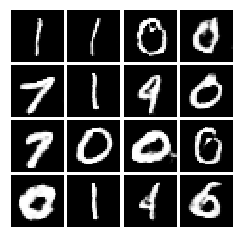


Iter: 3750, D: 0.988, G:3.154
Iter: 3800, D: 0.8862, G:1.875
Iter: 3850, D: 0.6663, G:1.314
Iter: 3900, D: 1.169, G:1.351
Iter: 3950, D: 0.7342, G:1.547


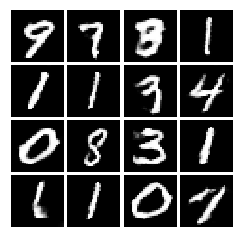


Iter: 4000, D: 0.7502, G:1.654
Iter: 4050, D: 0.8028, G:0.898
Iter: 4100, D: 0.6687, G:1.359
Iter: 4150, D: 0.7437, G:1.68
Iter: 4200, D: 1.067, G:2.951


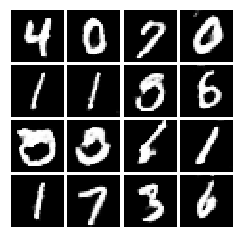


Iter: 4250, D: 0.7525, G:1.901
Iter: 4300, D: 0.7947, G:1.584
Iter: 4350, D: 0.6494, G:1.342
Iter: 4400, D: 0.8393, G:2.446
Iter: 4450, D: 0.7334, G:2.004


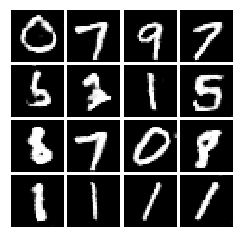


Iter: 4500, D: 0.628, G:1.365
Iter: 4550, D: 0.5769, G:1.92
Iter: 4600, D: 0.8039, G:1.062
Iter: 4650, D: 0.7442, G:1.85
Iter: 4700, D: 0.6838, G:2.469


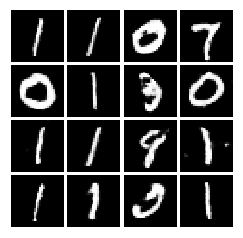


Iter: 4750, D: 0.7989, G:1.27
Iter: 4800, D: 0.7443, G:2.31
Iter: 4850, D: 0.8293, G:1.954
Iter: 4900, D: 0.675, G:1.829
Iter: 4950, D: 0.9906, G:1.16


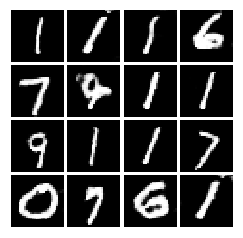


Iter: 5000, D: 0.6686, G:1.541
Iter: 5050, D: 0.6302, G:2.326
Iter: 5100, D: 0.6665, G:1.815
Iter: 5150, D: 0.5868, G:2.086
Iter: 5200, D: 0.5697, G:2.198


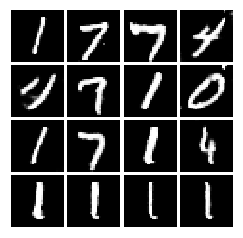


Iter: 5250, D: 0.8886, G:3.501
Iter: 5300, D: 0.5535, G:1.952
Iter: 5350, D: 0.5555, G:1.528
Iter: 5400, D: 0.6501, G:1.144
Iter: 5450, D: 0.7028, G:1.589


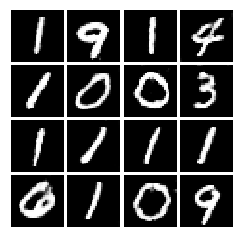


Iter: 5500, D: 1.19, G:1.53
Iter: 5550, D: 0.5846, G:1.833
Iter: 5600, D: 0.5952, G:2.313
Iter: 5650, D: 0.5564, G:2.612
Iter: 5700, D: 0.5444, G:1.521


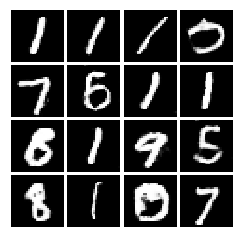


Iter: 5750, D: 0.6465, G:1.799
Iter: 5800, D: 0.5592, G:1.685
Iter: 5850, D: 0.5872, G:1.913
Iter: 5900, D: 0.5657, G:2.386
Iter: 5950, D: 0.62, G:2.29


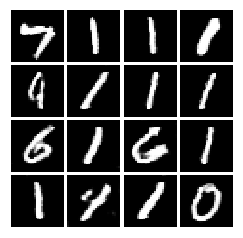


Iter: 6000, D: 0.656, G:2.067
Iter: 6050, D: 0.7039, G:2.45
Iter: 6100, D: 0.5756, G:1.528
Iter: 6150, D: 0.569, G:1.945
Iter: 6200, D: 0.6926, G:1.344


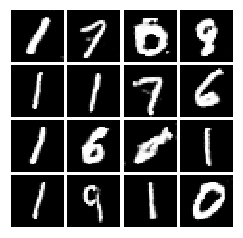


Iter: 6250, D: 0.6786, G:1.614
Iter: 6300, D: 0.6719, G:1.98
Iter: 6350, D: 0.5871, G:2.047
Iter: 6400, D: 0.6501, G:2.542
Iter: 6450, D: 0.6046, G:2.227


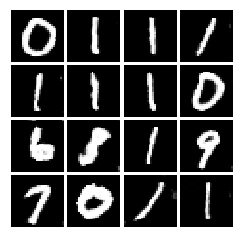


Iter: 6500, D: 0.5184, G:1.944
Iter: 6550, D: 0.553, G:1.991
Iter: 6600, D: 0.4727, G:2.435
Iter: 6650, D: 0.5092, G:2.577
Iter: 6700, D: 0.5454, G:1.889


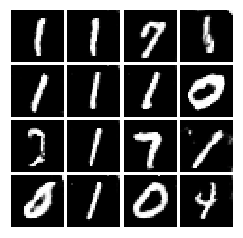


Iter: 6750, D: 0.6235, G:2.413
Iter: 6800, D: 0.7962, G:3.818
Iter: 6850, D: 0.5888, G:2.845
Iter: 6900, D: 0.4343, G:2.32
Iter: 6950, D: 0.4742, G:2.087


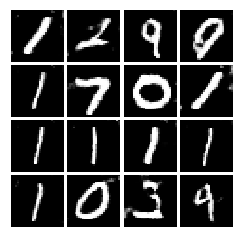


Iter: 7000, D: 0.5139, G:2.064
Iter: 7050, D: 0.5091, G:2.215
Iter: 7100, D: 0.565, G:2.071
Iter: 7150, D: 0.5342, G:1.929
Iter: 7200, D: 0.5014, G:1.737


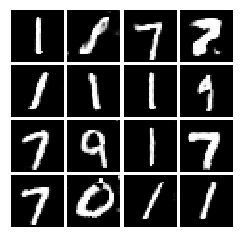


Iter: 7250, D: 0.6044, G:2.118
Iter: 7300, D: 0.5182, G:2.723
Iter: 7350, D: 0.4952, G:1.761
Iter: 7400, D: 0.5752, G:2.624
Iter: 7450, D: 0.5051, G:1.952


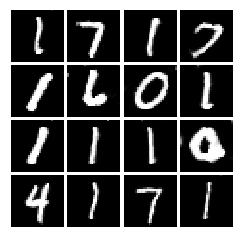


Iter: 7500, D: 0.4287, G:2.016
Iter: 7550, D: 0.445, G:2.028
Iter: 7600, D: 0.6307, G:2.256
Iter: 7650, D: 0.6352, G:2.998
Iter: 7700, D: 0.6255, G:2.966


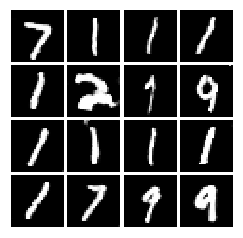


Iter: 7750, D: 0.5414, G:2.497
Iter: 7800, D: 0.8043, G:1.464
Iter: 7850, D: 0.4277, G:2.703
Iter: 7900, D: 0.4382, G:2.15
Iter: 7950, D: 0.3838, G:2.407


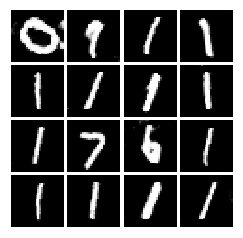


Iter: 8000, D: 0.3985, G:2.282
Iter: 8050, D: 0.5566, G:2.54
Iter: 8100, D: 0.4153, G:2.189
Iter: 8150, D: 0.5704, G:1.719
Iter: 8200, D: 0.5463, G:1.502


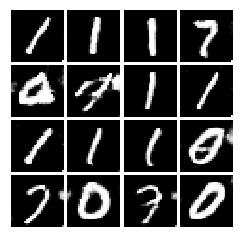


Iter: 8250, D: 0.4654, G:2.441
Iter: 8300, D: 0.4613, G:2.034
Iter: 8350, D: 0.6248, G:1.111
Iter: 8400, D: 0.4278, G:2.034
Iter: 8450, D: 0.4766, G:1.675


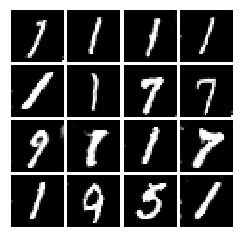


Iter: 8500, D: 0.4869, G:2.217
Iter: 8550, D: 0.5725, G:2.646
Final images


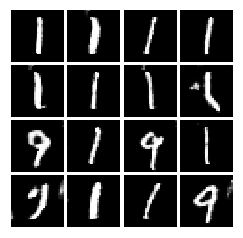

In [21]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=20)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

** (Write Your Answer In This Cell) **

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [ ]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        pass
        return logits
test_discriminator(3411649)

In [ ]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [ ]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = None
    G_loss = None

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = 0
    x_hat = 0

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = None

    grad_norm = None
    grad_pen = None



    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

In [ ]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)